In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class LoadData:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        data = pd.read_csv(self.file_path)
        return data

    def prepare_data(self, data):
        # Convertir la columna "Ronda" en variables dummy
        data = pd.get_dummies(data, columns=['Ronda'], drop_first=True)

        # Suponiendo que tu DataFrame se llama 'dataframe'
        data['MarcanAmbos'] = (data['GolesLocal'] > 0) & (data['GolesVisitante'] > 0)
        data['MarcanAmbos'] = data['MarcanAmbos'].astype(int)

        # Eliminar columnas irrelevantes
        data = data.drop(['idPartido', 'Temporada', 'Evento', 'GolesLocal', 'GolesVisitante'], axis=1)

        # Separar características y etiquetas
        X = data.drop(['VictoriaLocal', 'Empate', 'VictoriaVisitante', 'MarcanAmbos'], axis=1)
        y = data['MarcanAmbos']

        # Escalar características
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Dividir los datos en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
        
        # Convertir los datos a tensores
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test.values, dtype=tf.float32)
        
        return X_train, X_test, y_train, y_test, scaler, X, y
    
# Cargar los datos
data_loader = LoadData('../dataframe/champions.csv')
data = data_loader.load_data()
X_train, X_test, y_train, y_test, scaler, X, y = data_loader.prepare_data(data)

In [15]:
X_train.shape

TensorShape([1745, 29])

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

class Model:
    def __init__(self, configurations):
        self.configurations = configurations
        self.best_model = None
        self.best_config = None
        self.best_accuracy = 0

    def train_model(self, X_train, y_train):
        tf.random.set_seed(0)
        for config in self.configurations:
            model = Sequential([
                Dense(config['units'], activation='relu', input_shape=(X_train.shape[1],)),
                Dropout(config['dropout']),
                Dense(config['units'], activation='relu'),
                Dropout(config['dropout']),
                Dense(1, activation='sigmoid')
            ])

            optimizer = Adam(learning_rate=config['learning_rate'])
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

            history = model.fit(X_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'], validation_split=0.1)
            self.history = history
            
            
            _, accuracy = model.evaluate(X_test, y_test)
            
            if accuracy > self.best_accuracy:
                self.best_accuracy = accuracy
                self.best_model = model
                self.best_config = config

    
    def get_best_model(self):
        return self.best_model
    
    def get_best_config(self):
        return self.best_config
    

# Definir diferentes configuraciones de red y hiperparámetros

configurations = [
    {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.2},
    {'units': 128, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 15, 'dropout': 0.1},
    {'units': 256, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 10, 'dropout': 0.3},
    {'units': 128, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'dropout': 0.2},
    {'units': 256, 'filters': 128, 'kernel_size': 3, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 10, 'dropout': 0.1},
    {'units': 64, 'filters': 32, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 10, 'dropout': 0.1},
    {'units': 128, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20, 'dropout': 0.2},
    {'units': 256, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 15, 'dropout': 0.2},
    {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 20, 'dropout': 0.3},
    {'units': 128, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.2},
    {'units': 256, 'filters': 128, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 15, 'dropout': 0.1},
    {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 10, 'dropout': 0.1},
    {'units': 128, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.1}
]



model_trainer = Model(configurations)
model_trainer.train_model(X_train, y_train)

model = model_trainer.get_best_model()
best_config = model_trainer.get_best_config()
print("Mejor configuración:", best_config)


Epoch 1/10


/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4948 - loss: 0.7152 - val_accuracy: 0.4971 - val_loss: 0.7064
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.5301 - loss: 0.6963 - val_accuracy: 0.4686 - val_loss: 0.7017
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.5561 - loss: 0.6888 - val_accuracy: 0.5200 - val_loss: 0.6994
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.5136 - loss: 0.6946 - val_accuracy: 0.5200 - val_loss: 0.6922
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.5712 - loss: 0.6771 - val_accuracy: 0.5314 - val_loss: 0.6946
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.5531 - loss: 0.6791 - val_accuracy: 0.5200 - val_loss: 0.6951
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.5750 - loss: 0.6785 - val_accuracy: 0.5257 - val_loss: 0.6969
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.5471 - loss: 0.6881 - val_accuracy: 0.5429 - val_lo

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.5732 - loss: 0.6904
Loss: 0.6927255988121033
Accuracy: 0.564752995967865
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
[[209 178]
 [148 214]]


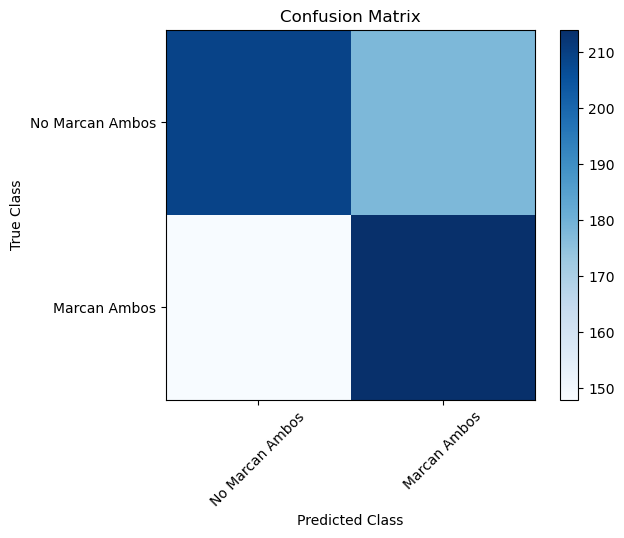

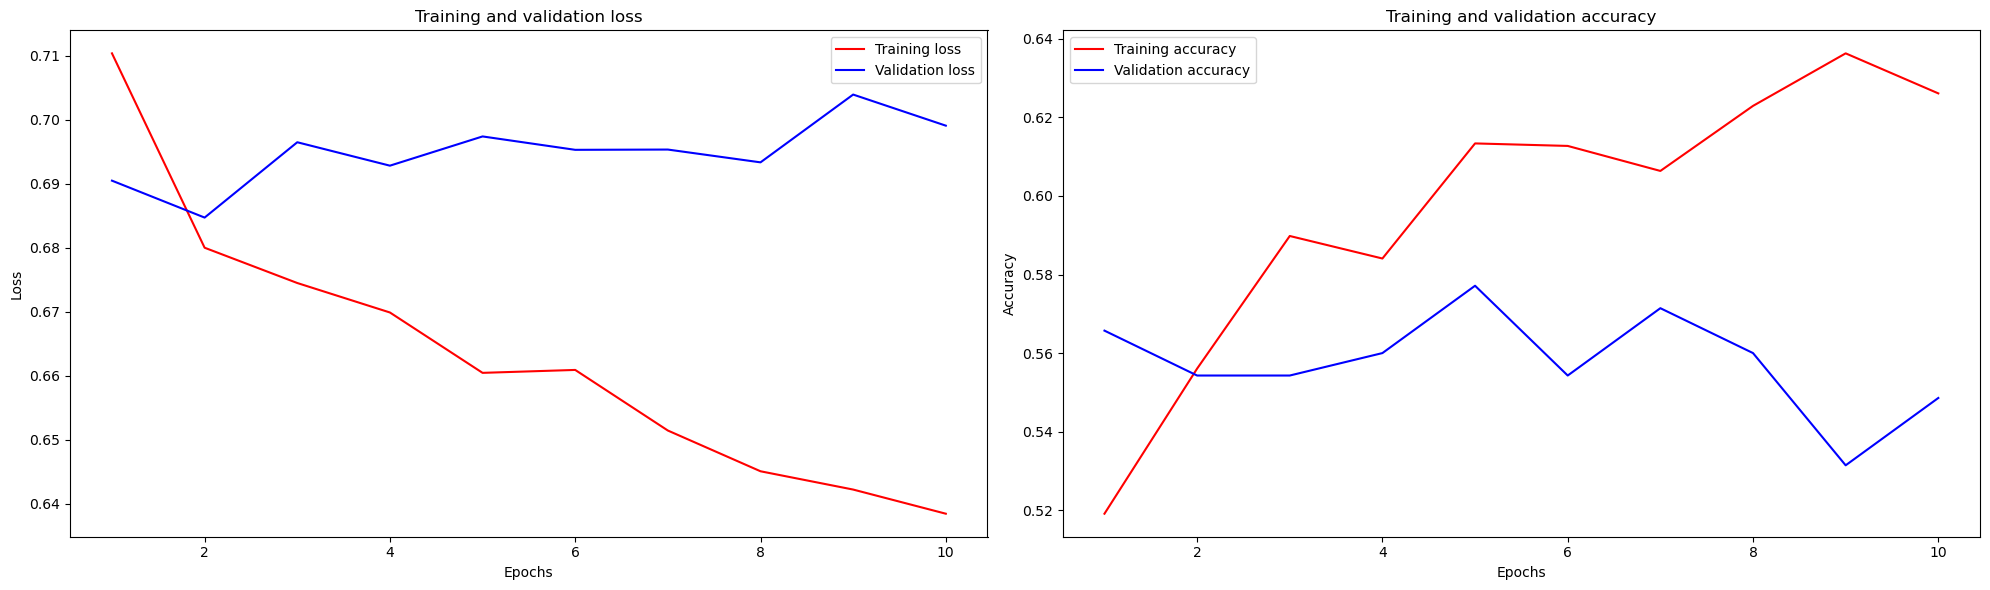

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix

class ModelEvaluation:
    def __init__(self, model):
        self.model = model
    
    def evaluate_model(self, X_test, y_test):
        # Evaluar el modelo
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print("Loss:", loss)
        print("Accuracy:", accuracy)

        # Generar predicciones
        class_probabilities = self.model.predict(X_test)
        predictions = np.round(class_probabilities).flatten()
        true_labels = y_test.numpy().flatten()

        # Calcular y mostrar la matriz de confusión
        conf_matrix = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:")
        print(conf_matrix)

        self.plot_matriz_confusion(conf_matrix)

    def plot_matriz_confusion(self, conf_matrix):
        # Visualizar la matriz de confusión
        plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['No Marcan Ambos', 'Marcan Ambos'], rotation=45)
        plt.yticks(tick_marks, ['No Marcan Ambos', 'Marcan Ambos'])
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title("Confusion Matrix")
        plt.show()

    @staticmethod
    def plot_learning_curve_tf(history):
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        train_accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        
        epochs = range(1, len(train_loss) + 1)
        
        plt.figure(figsize=(20, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
        plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.savefig('../resultados/learning_curve_dnnambos.png')
        plt.show()


model_evaluator = ModelEvaluation(model)
model_evaluator.evaluate_model(X_test, y_test)

ModelEvaluation.plot_learning_curve_tf(model_trainer.history)

In [18]:
# Guardar el modelo
tf.keras.models.save_model(model, '../modelos/dnn_ambos_marcan.keras')
model = tf.keras.models.load_model("../modelos/dnn_ambos_marcan.keras")

In [19]:
#!jupyter nbconvert --to script dnn_marcanambos.ipynb